### state
distance from avg hsv of orange + blue times number of max
### action
press one key, both, or none (direction of distance determines which keys)
### rewards
score update

$Q[s,a] ← Q[s,a] + α(r+ γ max_{a'} Q[s',a'] - Q[s,a])$

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
# params
alpha = 0.95
gamma = 0.66
# for exploration
explore_n = 500
explore_rate = 0.004

In [3]:
# save data
Q_vals = np.zeros([100, 3]) # 100 intensities 3 actions
trained_n = 0 # keep track of how many times we've updated Q

In [4]:
def select_action(state):
    return np.argmax(Q_vals[state,:])

def explore(state):
    # with certain probability return random action
    random_test = np.random.random() < (1 / (1 + np.exp(explore_rate * (trained_n - explore_n))))
    if random_test:
        # want to do nothing most often..
        return int(np.floor(np.random.exponential(0.5) % 3))
    else:
        # otherwise just most util
        return select_action(state)

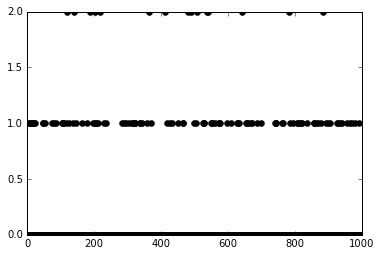

In [5]:
plt.plot([explore(0) for _ in range(1000)], 'ko')

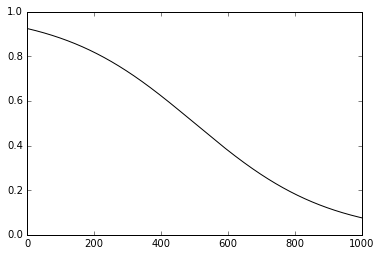

In [26]:
x = np.arange(0, 1000, 0.25)
def f(x):
    return 1 / (1 + np.exp( 0.005 * (x - 500)))

plt.plot(x, f(x), 'k')
plt.show()

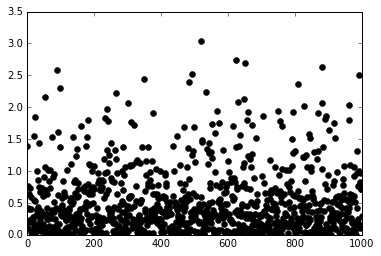

In [182]:
plt.plot(np.random.exponential(0.5, 1000), 'ko')

### train
press any buttons chosen + step
screenshot
### analyze
figure out space (color hist thing)
check if score different
   if yes update q-vals
try new action


In [7]:
last_state_action_pairs = []
last_reward = 0

Q[s,a] for last state / last action combo += discounted reward + gamma * max over actions Q(current state, actions)

In [29]:
# we're gna have a gamma prior on our next state...
from scipy.stats import gamma

In [103]:
# for finding our weighted avg max q-val we precompute some things
pre_comp_gamma = np.zeros([100, 100])
pre_comp_gamma_sum = np.zeros(100)
def precompute_gamma_weights():
    start_x = np.arange(0.1, 10.1, 0.1)
    for i in range(100):
        dist = gamma((i + 1) / 10)
        pre_comp_gamma[i] = dist.pdf(start_x)
    pre_comp_gamma_sum = np.sum(pre_comp_gamma, axis=1)

In [104]:
def find_weighted_max_q_val(last_state):
    # weighted mean
    wm_t = np.sum(np.multiply(Q_vals.transpose(), pre_comp_gamma[last_state]), axis=1)
    wm = wm_t / pre_comp_gamma_sum[last_state]
    return np.max(wm)

In [105]:
# accessing q Q_vals[(50,2)] (state, action)
# reward factor constant (must be > 1)
r_f = 1.25

def update_q(new_reward):
    # normalize reward
    n_reward = new_reward * (np.sign(new_reward - last_reward) + r_f) / (1 + r_f)
    # update last reward..
    last_reward = new_reward
    for t, sap in enumerate(last_state_action_pairs):
        max_a_q = find_weighted_max_q_val(sap[0])
        # i had (gamma ** (t + 1)) in here.. but i dont think extra discounting is necessary?
        # we should apply what we've learned to everything equally after getting feedback.
        Q_vals[sap] += alpha * (n_reward + (gamma * max_a_q) - Q_vals[sap])

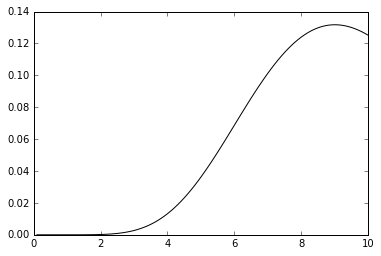

In [68]:
plt.plot(np.arange(0.1, 10.1, 0.1), pre_comp_gamma[99], ls='-', color='black')
plt.show()

i realized i want to shift the window a little forward in order to have a non-symmetric mapping of state-space to (expected) reward
otherwise things that we've already missed pressing will be in same state as things we can still press in time!

In [ ]:
# let's try to do that with the nicely written funs...

In [106]:
import os
os.chdir('../') # RUN ONCE ONLY

In [125]:
from tAIko.brains import imaging

In [115]:
imh = imaging.ImageHelper()
extract_path = './resources/taikotemp/recordings/extracted'

In [111]:
def show_screen(scrot_as_array):
    plt.figure(figsize=(5,10))
    plt.axis('off')
    plt.imshow(scrot_as_array, interpolation ='none')
    plt.show()

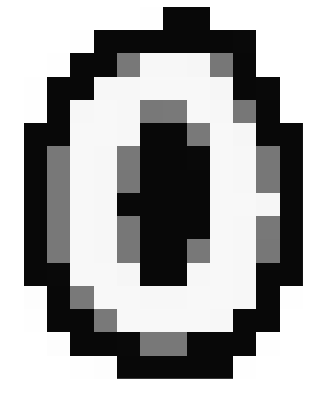

In [114]:
show_screen(imh.clean_array_mask(0))
# nice!

In [126]:
a_frame = imh.clean_pic(extract_path + '/out-75.png')

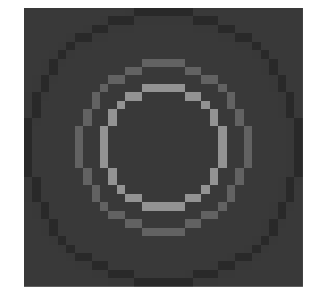

In [128]:
show_screen(a_frame[75:108, 13:46, :])

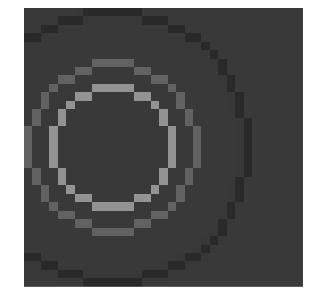

In [134]:
o = 6
snippy = a_frame[75:108, 13+o:46+o, :]
show_screen(snippy)

now it is time to begin!

In [ ]:
# TODO
# ds control
# - need to detect lvl finish in order to restart & select another lvl
# - frameskip of 2
# training..
# - start lvl
# - start taking screenshots
# - every frame(skip) pick action
# - analyze score
#   - update q's
# - once done training, dump q_vals
# testing..
# - same as training except don't analyze score

# what this will look like
# first add lvl-detect finish (screen becomes all black..)
# instantiate control, brains, imagehelp
# and then just throw everything else in separate step funs (for training/testing)
# add some ffmpeg magic to make vid